In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans , DBSCAN

## 1. 데이터 생성 및 전처리

In [2]:
df_raw = pd.read_csv('./Data/직무능력평가.csv', engine='python',encoding='cp949')

df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


### 전처리

In [3]:
scaler = StandardScaler()

df_raw_scaled = scaler.fit_transform(df_raw)
df_raw_scaled[:5]

array([[-1.8076031 , -1.19166169, -1.92300586, -1.50494461, -0.35542617,
         1.77141034,  0.20430138],
       [-0.13647543, -0.19861028, -0.17733772, -0.20508842, -0.15977874,
        -0.18159526,  0.4020124 ],
       [ 0.53197564,  0.25972114,  1.23582221,  1.09476777,  1.11192959,
         1.15467173,  0.50086791],
       [-0.30358819, -0.27499885, -0.67610004, -0.81168798, -1.0401922 ,
         0.9490922 , -0.78425369],
       [ 1.36753948,  0.87082969,  0.23829756,  0.83479653,  0.622811  ,
         0.84630243,  0.4020124 ]])

In [4]:
df_raw_y = df_raw_scaled[:,0]
df_raw_x = df_raw_scaled[:,1::]


### Dendogram

In [5]:
Z_ward = linkage(df_raw_x, method='ward', metric= 'euclidean')
Z_average = linkage(df_raw_x, method='average', metric= 'euclidean')
Z_Minkowski = linkage(df_raw_x, method='average', metric= 'minkowski')

Text(0, 0.5, 'sample index')

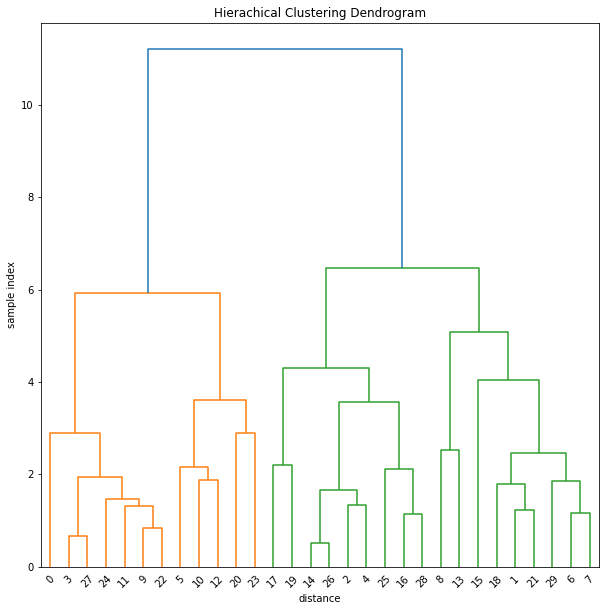

In [23]:
#### Z_ward
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

dendrogram(Z_ward, leaf_font_size=10, orientation= 'top')
plt.title ("Hierachical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

Text(0, 0.5, 'sample index')

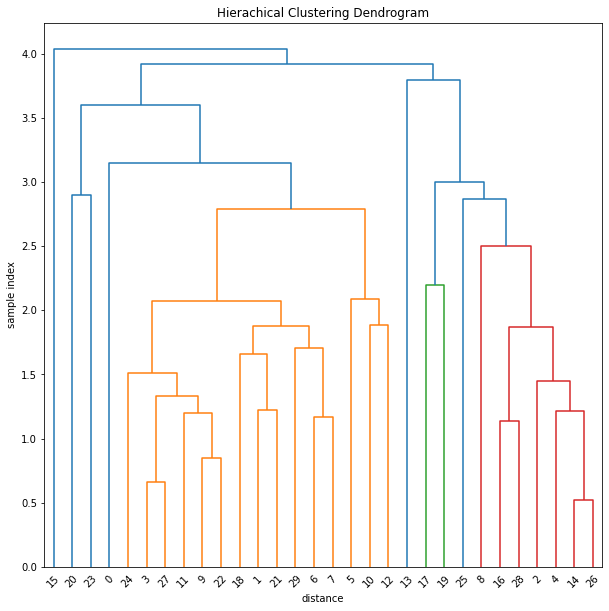

In [26]:
#### Z_average-euclidean
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

dendrogram(Z_average, leaf_font_size=10, orientation= 'top')
plt.title ("Hierachical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

Text(0, 0.5, 'sample index')

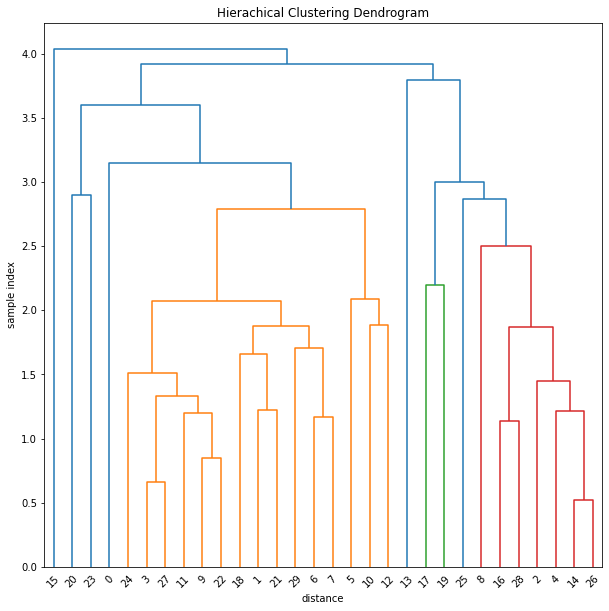

In [25]:
#### Z_average-minkowski
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

dendrogram(Z_Minkowski, leaf_font_size=10, orientation= 'top')
plt.title ("Hierachical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

- Z_average의 경우 metric에 상관없이 성능이 동일하게 나온다.

### 2. 계층별 군집생성

In [27]:
## 군집생성

cluster_hierachical = fcluster(Z=Z_ward, t = 5, criterion= 'distance')

df_raw['ClusterHierarchical'] = cluster_hierachical
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans
0,43,51,30,39,61,92,45,1,5
1,63,64,51,54,63,73,47,5,3
2,71,70,68,69,76,86,48,3,1
3,61,63,45,47,54,84,35,1,5
4,81,78,56,66,71,83,47,3,1


In [29]:
## 군집 프로파일링 (군집별 데이터 요약)

ds_summary_hc = df_raw.groupby('ClusterHierarchical').agg(['min','mean','max'])

level0 = ds_summary_hc.columns.get_level_values(0)
level1 = ds_summary_hc.columns.get_level_values(1)

ds_summary_hc.columns = level0 + '_' + level1
ds_summary_hc.reset_index(inplace = True)

ds_summary_hc.round(3)

,ClusterHierarchical,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max,ClusterKmeans_min,ClusterKmeans_mean,ClusterKmeans_max
0,1,43,57.429,67,51,58.857,66,30,43.571,52,...,66,74,81.143,92,33,38.571,45,5,5.000,5
1,2,40,53.200,69,37,49.400,62,33,46.800,57,...,58,49,60.000,67,25,35.000,49,4,4.000,4
2,3,50,71.889,85,58,73.889,85,54,63.333,71,...,88,74,79.000,86,46,54.667,72,1,1.222,2
3,4,68,70.000,72,82,82.500,83,72,77.500,83,...,71,77,80.000,83,31,33.000,35,1,1.500,2
4,5,58,69.143,82,61,72.714,90,39,47.143,52,...,75,54,72.000,85,35,40.714,47,1,2.714,3


In [11]:
## k-means 군집분석
n_iter_cluster =15
cluster_range = [i+1 for i in range (n_iter_cluster)]
clus_error =[]

for v_n_clus in cluster_range:
    clus =KMeans (v_n_clus)
    clus.fit (df_raw_x)
    clus_error.append(clus.inertia_)
    
ds_error = pd.DataFrame({"NumberofCluster":cluster_range, "Error": clus_error})
ds_error

,NumberofCluster,Error
0,1,180.000000
1,2,114.082503
2,3,94.434152
3,4,79.968676
4,5,69.271289
5,6,59.516606
6,7,50.621529
7,8,44.571309
8,9,40.194726
9,10,32.197092


- 군집 개수가 증가함에 따라 중심점까지의 거리는 가까워짐 (Error - 거리 제곱을 뜻함)

Text(0, 0.5, 'Sum of squared distance')

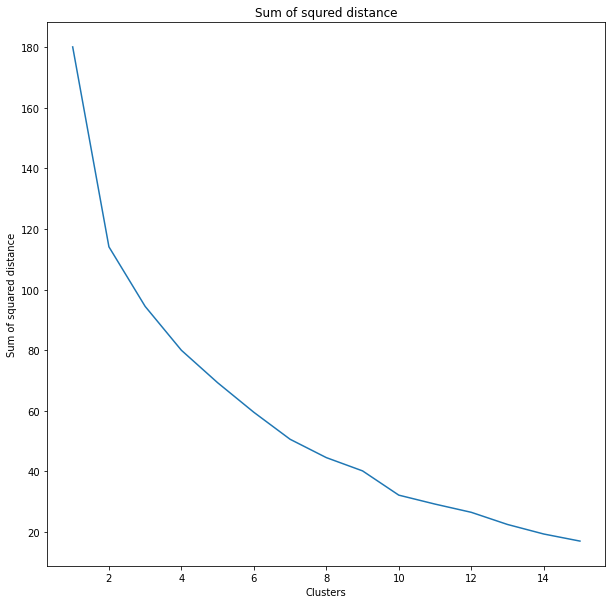

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(ds_error["NumberofCluster"], ds_error["Error"])
plt.title("Sum of squred distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

### 3. K-평균 군집 번호 생성

In [13]:
clus = KMeans(5)
clus.fit(df_raw_x)
cluster_kmeans = [i+1 for i in clus.labels_]
df_raw["ClusterKmeans"] = cluster_kmeans
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans
0,43,51,30,39,61,92,45,1,5
1,63,64,51,54,63,73,47,5,3
2,71,70,68,69,76,86,48,3,1
3,61,63,45,47,54,84,35,1,5
4,81,78,56,66,71,83,47,3,1


### K평균 군집별 데이터 요약

In [16]:
ds_summary_km = df_raw.drop("ClusterHierarchical", axis = 1, inplace=False).groupby("ClusterKmeans").agg(["min", "mean", "max"])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + "_" + level1
ds_summary_km.reset_index(inplace=True)
ds_summary_km.round(3)

,ClusterKmeans,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,65,74.333,85,70,77.667,85,46,61.667,72,...,74,71,77.333,88,74,80.111,86,31,50.778,72
1,2,50,61.000,68,58,67.000,83,65,72.000,83,...,75,55,59.333,64,77,78.333,80,35,49.000,60
2,3,58,69.833,82,61,73.167,90,39,47.333,52,...,72,60,64.833,70,54,69.833,80,35,39.833,47
3,4,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
4,5,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45


## 4. DBSCAN군집분석

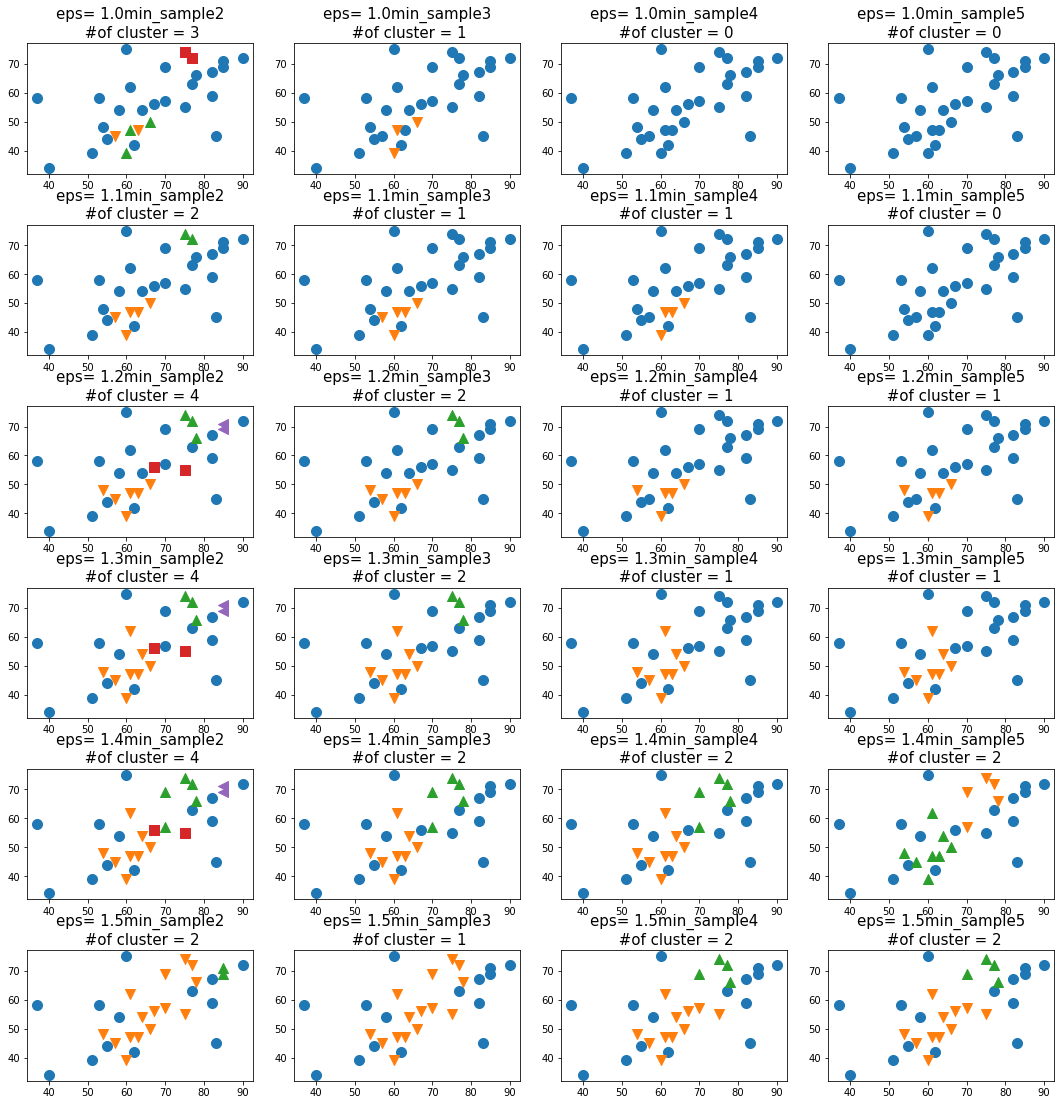

In [32]:
X=df_raw["DISSATIS"]
Y=df_raw["CHANCE"]

# 데이터 point 그림 종류
markers = ["o", "v", "^", "s", "<", ">", "p", "D"]
para_eps = [k/10 for k in range(10, 16, 1)]
para_min_sample = [2, 3, 4, 5]

# subplot
fig, axes = plt.subplots(len(para_eps), len(para_min_sample), figsize=(15, 15)) # plot 개수
fig.tight_layout(w_pad=1, h_pad=3)

for i, eps in enumerate(para_eps):
    for j, min_sample in enumerate(para_min_sample):
        # DBSCAN 생성
        dbscan = DBSCAN(min_samples=min_sample, eps=eps)
        clusters=dbscan.fit_predict(df_raw_x) #예측 분류
        clusters=clusters+1 #noise의 경우 -1로 표기되므로 1씩 더하여 0으로 변환
        for (n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1, 1)): #군집별로 다른 그림 지정
            axes[i, j].scatter(X[clusters==clus], Y[clusters==clus], marker=markers[n_clus], s=100)
            axes[i, j].set_title("eps= "+str(eps) + "min_sample" + str(min_sample) + "\n #of cluster = " + str(max(clusters)), fontsize=15)

- eps=1.4, min_sample=2: 거리가 길고 최소 자료 수가 적으면 군집이 여러 개 생성
- eps=1, min_sample=5: 거리가 짧고 최소 자료 수가 많아 군집이 생성되지 않음

- eps: 특정 데이터로부터 다른 데이터를 포함하는 거리
- min_samples: 군집이 되기 위한 최소 데이터 수

In [35]:
dbscan = DBSCAN(eps=1.4, min_samples=2).fit(df_raw_x)
cluster_dbscan = dbscan.labels_

## sklearn의 DBSCAN에서는 noise 데이터의 경우 군집이 -1로 표시되며 0번 군집부터 시작
## 다른 계층형, K-평균은 1번 군집부터 시작하므로 다른 군집 번호와 통일. Noises데이터는 0번 군집으로 표기

for i, val in enumerate(cluster_dbscan):
    if val< 0:
        cluster_dbscan[i]=0
    else:
        clustr_dbscan[i] = cluster_dbscan[i]+1
df_raw["ClusterDBScan"] = cluster_dbscan
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans,ClusterDBScan
0,43,51,30,39,61,92,45,1,5,0
1,63,64,51,54,63,73,47,5,3,0
2,71,70,68,69,76,86,48,3,1,1
3,61,63,45,47,54,84,35,1,5,0
4,81,78,56,66,71,83,47,3,1,1


In [37]:
ds_summary_db = df_raw.drop(["ClusterHierarchical", "ClusterKmeans"], axis=1, inplace=False).groupby("ClusterDBScan").agg(["min", "mean", "max"])
level0 = ds_summary_db.columns.get_level_values(0)
level1 = ds_summary_db.columns.get_level_values(1)
ds_summary_db.columns = level0 + "_" + level1
ds_summary_db.reset_index(inplace=True)
ds_summary_db.round(3)

,ClusterDBScan,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,0,40,60.905,82,37,62.667,90,30,51.667,83,...,75,43,60.286,88,49,73.667,92,25,40.857,72
1,1,65,74.400,81,70,74.000,78,46,56.400,68,...,74,71,76.200,80,77,81.800,86,46,47.200,49
2,2,58,64.500,71,67,71.000,75,42,46.000,50,...,56,66,68.000,70,66,67.000,68,35,38.000,41
3,3,74,79.500,85,85,85.000,85,64,67.500,71,...,71,77,78.000,79,74,76.500,79,55,59.000,63


- 각 군집별 변수 분포가 다름(평균 등 통계량 확인)

- 목표변수가 있는 데이터의 경우 y변수를 보지 않은 상태로 설명변수를 넣고 군집분석을 실시한 후 목표변수와 비교하는 방식으로 사용해도 됨